In [1]:
%load_ext autoreload
%autoreload 2
import gc
import re
import pandas as pd
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
import os
import sys
HOME = os.path.expanduser("~")
sys.path.append(f'{HOME}/kaggle/data_analysis/library')
import utils
from utils import get_categorical_features, get_numeric_features, reduce_mem_usage
from preprocessing import get_dummies
import datetime

from tqdm import tqdm
import time
import sys

os.listdir('../input/')
key = 'card_id'
target = 'target'
ignore_list = [key, target, 'merchant_id', 'first_avtive_month']

In [44]:
import glob
from joblib import Parallel, delayed

path_list = glob.glob('../stack/*.gz')
base = utils.read_df_pkl('../input/base_first*0*').set_index(key)
base['first_active_month'].fillna('2017-03', inplace=True)

def concat_stack(path):
    tmp = utils.read_pkl_gzip(path).set_index(key)
    date = re.search(r'/([^/.]*)_stack', path).group(1)
    cv = re.search(r'CV([^/.]*)', path).group(1)
    if 'pred_mean' in tmp.columns:
        tmp = tmp['pred_mean']
        tmp.name =  f"{date}_{cv}"
    else:
        tmp = tmp['prediction']
        tmp.name =  f"{date}_{cv}"
    return tmp

pred_list = Parallel(n_jobs=-1)([delayed(concat_stack)(path) for path in path_list])
df_pred = pd.concat(pred_list, axis=1)
base = base.join(df_pred)

100%|██████████| 3/3 [00:00<00:00, 87.45it/s]


In [45]:
base.head()

,first_active_month,target,0128_135_3-6446885874930075_LB,0129_091_3-6421820883180707_LB,0130_193_5-24805823246483_LB,0130_174_3-310281513340206_LB,0130_131_4-287365410526872_LB,0128_235_3-650037974424863_LB,0112_125_3-649026127427298_LB,0130_113_8-155798454641898_LB,0112_100_3-648712226607567_LB,0130_154_3-64429282597835_LB,0111_084_3-649778904244731_LB,0130_183_6-667250276253759_LB,0129_100_3-641638637113398_LB,0109_223_1-5465657344282366_LB,0129_090_3-6429264104369503_LB,0129_095_3-641106016266762_LB,0128_133_3-643366297617407_LB,0111_102_3-6494249648406467_LB,0130_180_3-381002346822328_LB,0130_120_4-808329166660606_LB,0130_163_7-652020557732003_LB,0121_071_3-6520267723697666_LB,0128_122_3-6417387771988694_LB,0129_080_3-644452513571249_LB,0129_081_3-6434337612872225_LB,0109_190_4-103946343538847_LB,0129_082_3-6423406048662748_LB,0114_215_3-6527865752973177_LB,0129_082_3-6461086736452657_LB,0130_192_5-5869409029919925_LB,0130_115_4-433519061810081_LB,0110_210_3-664584024547711_LB,0129_002_3-6498086715716127_LB,0130_175_3-566062858690306_LB,0114_004_3-6505372648747247_LB,0130_141_4-661901629184544_LB,0130_155_3-426516480046737_LB,0129_104_3-6403137386948856_LB,0130_154_3-2526412277627452_LB,0130_174_3-7304007392524396_LB,0111_082_3-648879694681201_LB,0129_092_3-6438192716237765_LB,0130_165_4-90772381051495_LB,0129_002_3-6471011034364715_LB,0129_092_3-6440084809997373_LB,0115_222_3-649798655247443_LB,0107_012_3-647842318785019_LB,0115_234_3-652639795750401_LB,0130_103_3-7716349301445597_LB,0130_173_3-8055560563741566_LB,0120_200_3-6514966430026154_LB,0130_140_3-8766016994648522_LB,0129_094_3-642461794885702_LB,0114_010_3-6497211097385147_LB,0129_091_3-6426572813958784_LB,0129_085_3-6432164386149766_LB,0130_164_4-1250528593787665_LB,0130_161_4-08795025037205_LB,0109_082_3-6484994493282237_LB,0130_111_4-165154214294814_LB,0130_184_7-917904397766032_LB,0109_084_3-658775304476555_LB,0129_083_3-6432021299072446_LB,0130_143_4-642199756624356_LB,0130_163_5-627032636520041_LB,0129_094_3-643330263158923_LB,0129_105_3-63924831290732_LB,0130_124_4-642152733618808_LB,0112_084_3-649046125233803_LB,0128_121_3-6431692942772687_LB,0130_160_3-4248006894120318_LB,0130_102_3-2299353202981393_LB,0107_092_3-650884719039021_LB,0128_131_3-6393726839122764_LB,0109_102_3-6484994493282237_LB,0110_221_3-6527566399693434_LB,0130_132_3-9292507891210335_LB,0130_190_4-41717957381407_LB,0130_184_7-526536547094926_LB,0112_180_3-649515727422533_LB,0110_230_3-64958566806189_LB,0107_221_3-649821386872066_LB,0112_092_3-649268954801554_LB,0110_222_3-6527566399693425_LB,0129_090_3-643273149809964_LB,0128_131_3-6413716858127954_LB,0128_121_3-6422568532512316_LB,0129_090_3-643037373015832_LB,0130_172_5-412881854104323_LB,0130_110_3-5405213955231942_LB,0128_112_3-6439982330582543_LB,0128_151_3-6401903762222707_LB,0130_141_5-5920462708343965_LB,0130_134_4-372182999603839_LB,0128_132_3-6420408606516936_LB,0130_102_3-1408173036537397_LB,0113_092_3-650842460406126_LB,0130_132_3-893317483755587_LB,...,0129_084_3-6434252006901557_LB,0130_181_3-3731501716000354_LB,0122_235_3-6503384710582276_LB,0109_191_4-09782224622231_LB,0130_162_6-712429555178332_LB,0130_111_6-769575728886151_LB,0112_161_3-649133141540562_LB,0130_101_3-2703657019416936_LB,0128_134_3-6409525551362676_LB,0130_115_4-38966022113365_LB,0130_191_5-467872215202722_LB,0115_221_3-6514680644239106_LB,0121_081_3-652021636110317_LB,0109_215_3-5317518544372155_LB,0111_154_3-3530444409955336_LB,0128_123_3-643561659731674_LB,0130_113_7-790361087511494_LB,0129_094_3-6427273143450103_LB,0130_114_5-6928880852191_LB,0130_182_3-3696697841656444_LB,0129_085_3-642836526998495_LB,0130_130_4-205938438906571_LB,0112_163_3-3503452476449724_LB,0130_110_3-4234202748395886_LB,0114_215_3-653008658632465_LB,0110_083_3-6662646410644384_LB,0129_083_3-642935809014535_LB,0110_211_3-666769302305775_LB,0130_121_5-548004809070973_LB,0128_132_3-6419698340339814_LB,0130_180_3-0869532248915177_LB,0129_094_3-6438874436938584_LB,0112_145_1-5523449

In [49]:
pd.set_option('max_rows', 200)
from sklearn.metrics import mean_squared_error
#========================================================================
# Part of card_id Score


pred_cols = [col for col in base.columns if col not in ignore_list and col.count('LB')]

def get_fam_score(pred_col):

    base_train = base[~base[target].isnull()].reset_index().fillna(0)
    part_score_list = []
    part_N_list = []
    fam_list = []
    score_list = []

    for i in range(201101, 201713, 1):
        if i%100>12:
            continue
        fam = str(i)[:4] + '-' + str(i)[-2:]
        df_part = base_train[base_train['first_active_month']==fam]
        if len(df_part)==0:
            continue
        part_id_list = df_part[key].values
    
        part_train = base_train.loc[base_train[key].isin(part_id_list), :]
        y_train = part_train[target].values
        
        y_pred = part_train[pred_col].values
        # RMSE
        part_score = np.sqrt(mean_squared_error(y_train, y_pred))

        fam_list.append(fam)
        part_score_list.append(part_score)
        part_N_list.append(len(part_id_list))
    
    df = pd.DataFrame(np.asarray([fam_list, part_score_list, part_N_list]).T)
    df.columns = ['FAM', 'CV', 'N']
    df['name'] = pred_col
    return df
    
fam_score_list = Parallel(n_jobs=-1)([delayed(get_fam_score)(pred_col) for pred_col in pred_cols])

In [50]:
result = pd.concat(fam_score_list, axis=0)
result['yyyymm'] = result['FAM'].map(lambda x: int(x.replace('-', '')))
result['CV'] = result['CV'].astype('float64')
result = result[result['name']!='0109_223_1-5465657344282366_LB']
result.sort_values(by=['FAM', 'CV'], ascending=True, inplace=True)
df_row = utils.row_number(df=result, level='FAM')

viz_fam_min = '2012-01'
bench = df_row[df_row['name']=='0129_102_3-6389228323052527_LB']
bench = bench[bench['FAM']>=viz_fam_min]
bench['row_no'] = 'bench'
viz_all = df_row[df_row['row_no']<=20]
viz_all = viz_all[viz_all['FAM']>=viz_fam_min]
viz_all = pd.concat([bench, viz_all], axis=0, ignore_index=True)

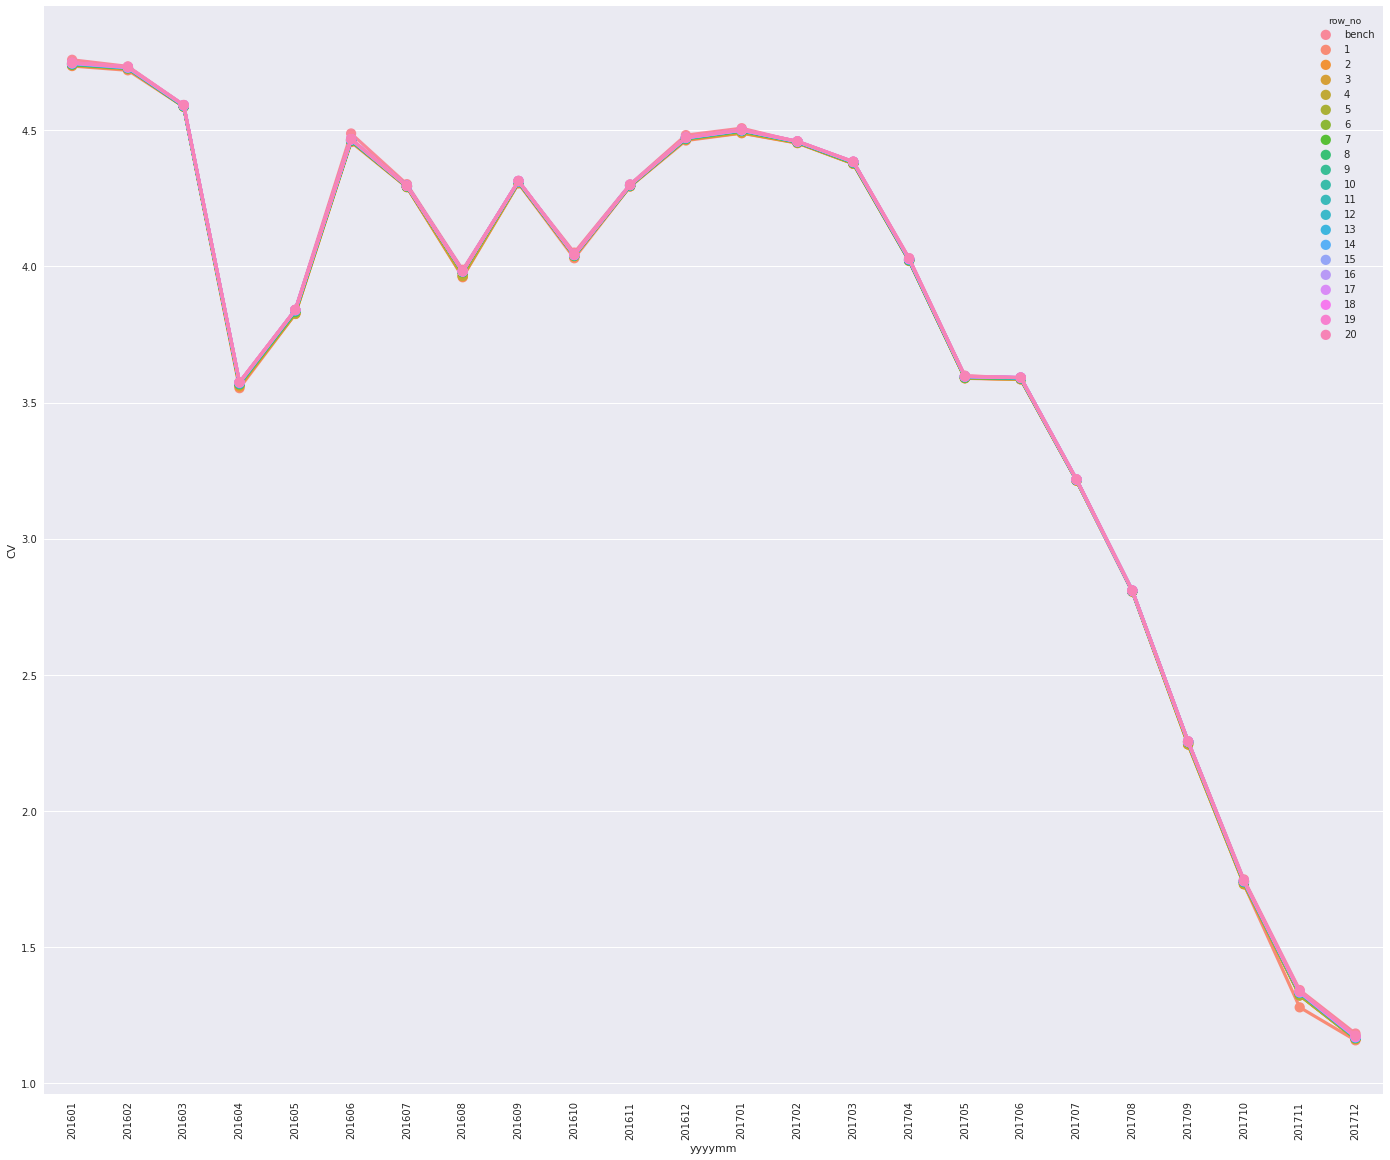

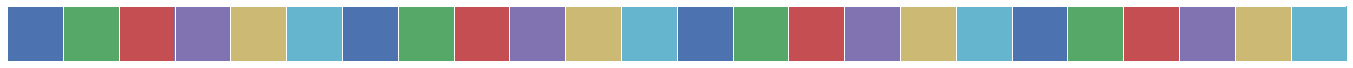

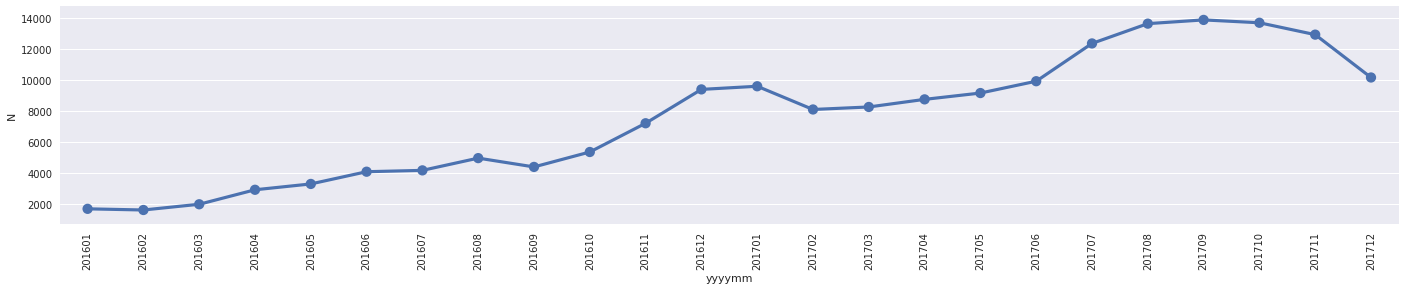

In [53]:
plt.figure(figsize=(24, 20))
sns.pointplot(x="yyyymm", y="CV", hue="row_no", data=viz_all[viz_all['yyyymm']>=201601])
plt.xticks(rotation=90)
plt.show()

viz_N = viz_all[['yyyymm', 'N']].drop_duplicates()
viz_N['N'] = viz_N['N'].astype('int')
# sns.color_palette()
current_palette = sns.color_palette(n_colors=24)
sns.palplot(current_palette)
plt.figure(figsize=(24, 4))
sns.pointplot(x="yyyymm", y="N", data=viz_N[viz_N['yyyymm']>=201601])
plt.xticks(rotation=90)
plt.show()

In [6]:
viz_N[viz_N['yyyymm']<201601]['N'].sum()

20076

### Stacking

In [98]:
# viz[viz['row_no']==1]
print(viz['name'].drop_duplicates().sort_values())
stack_list = list(viz['name'].drop_duplicates().sort_values().values)

In [103]:
df_stack = base[['first_active_month'] + stack_list]
df_stack[df_stack['first_active_month'].isnull()]

,first_active_month,0107_012_3-647842318785019_LB,0107_081_3-6479841522282994_LB,0107_093_3-651062157929207_LB,0108_230_3-653391743289176_LB,0109_002_3-6510445621835883_LB,0109_032_3-6495361065070235_LB,0109_075_3-649767935786786_LB,0109_082_3-6484994493282237_LB,0109_102_3-6484994493282237_LB,0109_190_4-103946343538847_LB,0109_232_3-650721287912713_LB,0110_084_3-6481742957158105_LB,0110_220_3-6538134540799314_LB,0111_230_1-5522737457708096_LB,0112_003_1-5522907274695075_LB,0112_145_1-5523449636910231_LB,0112_152_1-553463231177918_LB,0115_231_3-6517110742499903_LB,0121_073_3-6525207409388707_LB,0121_120_3-651502874923711_LB,0127_134_1-1447376968819327_LB,0127_172_1-2099208288475294_LB,0127_173_1-342296754460716_LB,0127_175_1-6708542570313902_LB,0127_211_2-2021427391280772_LB,0127_221_2-384300441070508_LB,0127_222_2-2980889515609357_LB,0127_223_2-257376325304439_LB,0127_231_2-255908575736_LB,0128_111_3-6453126772774533_LB,0128_112_3-6467642414517627_LB,0128_113_3-645476209152849_LB,0128_121_3-6422568532512316_LB,0128_121_3-6431692942772687_LB,0128_122_3-6416289213325883_LB,0128_122_3-6417387771988694_LB,0128_123_3-6423489132383366_LB,0128_131_3-6393726839122764_LB,0128_132_3-6420408606516936_LB,0128_133_3-6420123116122136_LB,0128_133_3-643335588478488_LB,0128_133_3-643366297617407_LB,0128_134_3-6437636232714596_LB,0128_140_3-6458362282339123_LB,0128_141_3-641677586209_LB,0128_143_3-640916075930967_LB,0128_151_3-6401903762222707_LB,0128_185_3-6450996834458325_LB,0128_235_3-650037974424863_LB,0128_235_3-650326671792132_LB,0129_002_3-6471011034364715_LB,0129_080_3-6439612210927614_LB,0129_080_3-644452513571249_LB,0129_082_3-6461086736452657_LB,0129_083_3-641490937126316_LB,0129_083_3-643876055752313_LB,0129_084_3-643120331861327_LB,0129_084_3-6436753443952803_LB,0129_085_3-642836526998495_LB,0129_085_3-6432164386149766_LB,0129_090_3-643273149809964_LB,0129_090_3-644227156146689_LB,0129_091_3-6432164386149766_LB,0129_094_3-6437895726923037_LB,0129_095_3-641106016266762_LB,0129_095_3-6432790318882597_LB,0129_100_3-641638637113398_LB,0129_102_3-6389228323052527_LB,0129_113_4-219239873913731_LB,0129_115_4-672855563381953_LB,0129_120_4-773282358824037_LB,0129_120_4-790552412852991_LB,0129_121_4-731983703353693_LB,0129_122_4-718847239449152_LB,0129_123_4-62312040224916_LB,0129_124_4-62396108891566_LB,0129_125_4-618996699719043_LB,0129_130_4-620191809405427_LB,0129_131_4-568802210057331_LB,0129_132_4-568443524680934_LB,0129_135_3-8450061744058757_LB,0129_140_3-844539272545398_LB,0129_141_3-971677987373801_LB,0129_161_4-324182430128594_LB,0129_162_4-327344007162399_LB,0129_163_4-243769363718849_LB,0129_164_4-244851069705214_LB,0129_170_4-251312519513768_LB,0129_171_4-2529568478823085_LB,0129_172_3-9848418940621158_LB,0129_173_3-984194209034718_LB,0129_174_4-0572974146077945_LB,0129_175_4-057156311662081_LB,0129_180_4-053964444693084_LB,0129_181_4-054772328231663_LB,0129_182_3-99633959083271_LB,0129_183_3-9963688665069137_LB,0129_184_3-997307809022973_LB,0129_190_3-9968886809662036_LB,0129_191_3-9404592469943593_LB,0129_192_3-9418662806179112_LB,0129_201_3-7427417934033516_LB,0129_203_3-7423173038863227_LB,0129_204_3-648865870067179_LB,0129_205_3-6488019495956956_LB,0129_224_3-1071051229341586_LB,0129_225_3-1081022704154733_LB,0129_231_2-457296347658727_LB,0129_232_2-458129845364634_LB,0130_002_4-769126225703413_LB,0130_003_4-769868875109866_LB,0130_004_4-699647645212613_LB,0130_004_4-702568054480066_LB,0130_005_4-637301652242733_LB,0130_010_4-641000715483561_LB,0130_013_4-402545222532054_LB,0130_014_4-401457335868492_LB,0130_021_4-383955582481393_LB,0130_022_4-382281992299876_LB,0130_023_4-028571815693278_LB,0130_024_4-22837752179676_LB,0130_025_4-228176107077543_LB,0130_032_3-6437370608365227_LB,0130_033_3-643513803589183_LB,0130_035_4-1611734634079625_LB,0130_040_4-163180130871127_LB,0130_041_4-034568152378766_LB,0130_042_4-032854240539249_LB,0130_043_3-845163747359752_LB,0130_044_3-844869901982271_LB
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [118]:
corr_cols = viz[viz['FAM']=='2017-09']['name'].values.tolist()

# df_fam = base[[target, 'first_active_month'] + corr_cols]
df_fam = base[['first_active_month'] + corr_cols[:4]]
df_fam = df_fam[df_fam['first_active_month']=='2017-09']
df_fam = df_fam[corr_cols[:4]]
df_fam['mean'] = df_fam.mean(axis=1)
df_fam

SystemExit: 

In [48]:
import shutil

path_list = glob.glob('../stack/*.gz')
for p in path_list:
    tmp = utils.read_pkl_gzip(p)
    pred_cols = [col for col in tmp.columns if col.count('pred_mean') or col=='prediction']
    for col in pred_cols:
        try:
            length = tmp[tmp[col].isnull()].shape[0]
            if length>0:
                print(p)
                print(col)
                shutil.move(p, '../stack/delete/')
        except ValueError:
            print(p)
            display(tmp.head())
            sys.exit()

KeyboardInterrupt: 